In [9]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import re
# from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

In [3]:
# Load JSON file and extract only the "abstract" and "date" fields
data = []
with open('arxiv-metadata-oai-snapshot.json', 'r') as f:
    for line in tqdm(f):
        json_data = json.loads(line)
        abstract = json_data.get("abstract")
        date = json_data.get("versions", [{}])[0].get("created")
        data.append({"abstract": abstract, "date": date})

# Create a DataFrame from the extracted data
df = pd.DataFrame(data)

# Convert date column to datetime format
df["date"] = pd.to_datetime(df["date"])

0it [00:00, ?it/s]

2408075it [00:17, 135647.87it/s]


In [4]:
# Very basic preprocessing
def preprocess_abstract(text):
    # Lowercase and remove punctuation
    text = re.sub(r"[^\w\s]", "", text.lower())
    # Tokenize
    tokens = text.split()
    return " ".join(tokens)

df["cleaned_abstracts"] = df["abstract"].apply(preprocess_abstract)

In [5]:
# Initialize TF-IDF vectorizer with stop words removed
vectorizer = TfidfVectorizer(stop_words="english", decode_error="ignore")

# Fit and transform abstracts into TF-IDF features
documents_tfidf = vectorizer.fit_transform(df["cleaned_abstracts"])

In [9]:
# # Apply dimensionality reduction with Truncated SVD (reduce computational load)
# svd = TruncatedSVD(n_components=15)
# reduced_features = svd.fit_transform(documents_tfidf)

In [ ]:
# Initialize KMeans clusterer
kmeans = MiniBatchKMeans(n_clusters=10, n_init=3, random_state=42)

# Fit the clusterer to features
kmeans.fit(documents_tfidf)

# Predict cluster labels for each document
clusters = kmeans.predict(documents_tfidf)

# Create a new column for predicted topics
df["main_topic"] = clusters

In [25]:
cluster_labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_
for cluster_index in range(len(cluster_centers)):
    centroid = cluster_centers[cluster_index]

    # Get top words and their TF-IDF scores
    top_word_indices = centroid.argsort()[-10:][::-1]
    top_words = [vectorizer.get_feature_names_out()[index] for index in top_word_indices]
    top_scores = centroid[top_word_indices]

    # Print top words and scores
    print(f"Cluster {cluster_index} Top Words:")
    for word, score in zip(top_words, top_scores):
        print(f"- {word} ({score:.4f})")

Cluster 0 Top Words:
- group (0.0852)
- groups (0.0586)
- algebra (0.0545)
- algebras (0.0464)
- lie (0.0344)
- finite (0.0257)
- prove (0.0174)
- representations (0.0158)
- cohomology (0.0157)
- let (0.0154)
Cluster 1 Top Words:
- quantum (0.1696)
- states (0.0388)
- state (0.0301)
- entanglement (0.0295)
- classical (0.0240)
- systems (0.0205)
- theory (0.0196)
- spin (0.0185)
- field (0.0169)
- phase (0.0160)
Cluster 2 Top Words:
- quark (0.0278)
- mass (0.0274)
- neutrino (0.0269)
- qcd (0.0249)
- production (0.0247)
- model (0.0226)
- decay (0.0222)
- higgs (0.0206)
- collisions (0.0200)
- energy (0.0188)
Cluster 3 Top Words:
- magnetic (0.0211)
- field (0.0157)
- phase (0.0153)
- temperature (0.0145)
- energy (0.0139)
- model (0.0132)
- stars (0.0129)
- galaxies (0.0121)
- observed (0.0120)
- emission (0.0118)
Cluster 4 Top Words:
- learning (0.0389)
- data (0.0389)
- models (0.0271)
- model (0.0258)
- training (0.0223)
- performance (0.0211)
- methods (0.0207)
- neural (0.0207)


In [22]:
# Create a year column with only the year from the date column
df["year"] = df["date"].dt.year

# Group by year and category
grouped_by_year_category = df.groupby(["year", "main_topic"])

# Count occurrences within each group
paper_counts = grouped_by_year_category.size().unstack()

# Fill missing values with 0
paper_counts.fillna(0, inplace=True)

# Uncomment to print the resulting table
# print(paper_counts)

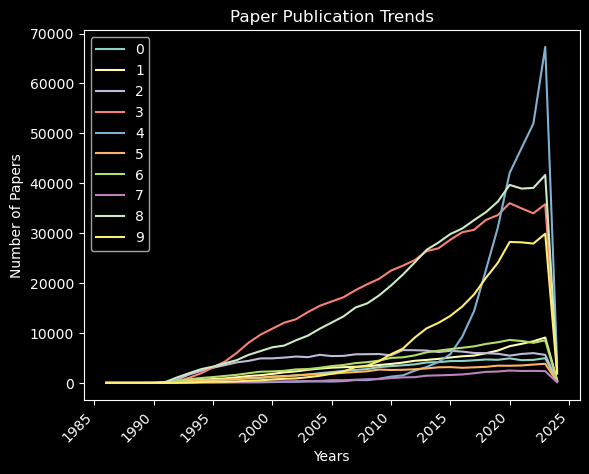

In [28]:
# Plot all the clusters
i = 0
while i < 10:
	plt.plot(paper_counts.index, paper_counts[i], label=i)
	i += 1

# Customize the plot with labels and title
plt.xlabel("Years")
plt.ylabel("Number of Papers")
plt.title("Paper Publication Trends")
plt.legend()

# Display the plot
plt.xticks(rotation=45, ha="right")
plt.style.use("dark_background")
plt.show()